![image.png](https://i.imgur.com/a3uAqnb.png)

# Multi-Modal Sentiment Analysis - Homework Assignment

![Combined Model Architecture](https://i.imgur.com/RVYyBe7.jpeg)

In this homework, you will build and compare three different models for sentiment analysis on a dataset of tweets, each containing both an image and text.

## 📌 Project Overview
- **Task**: Classify the sentiment of a tweet (positive, negative, or neutral) using its text, its image, and a combination of both.
- **Architecture**:
    1. An image-only model (CNN).
    2. A text-only model (RNN/LSTM/GRU).
    3. A combined, multi-modal model that fuses features from the two.
- **Dataset**: MVSA (Multi-view Social Data)
- **Goal**: Compare the performance of unimodal vs. multi-modal approaches for sentiment analysis.

## 📚 Learning Objectives
By completing this assignment, you will:
- Understand how to process a mixed-media dataset (images and text).
- Implement a CNN for image classification.
- Build an RNN/LSTM for text classification.
- Construct a multi-modal architecture by combining feature extractors.
- Evaluate and compare the performance of different models on the same task.

## 1️⃣ Dataset Setup (PROVIDED)

The MVSA dataset has been downloaded for you. The dataset structure is as follows:
- `labelResultAll.txt`: A file containing the labels for each data point. The format is `tweet_id,label`.
- `data/`: A folder containing all the image (`.jpg`) and text (`.txt`) files, named by their tweet ID.

In [1]:
import kagglehub
import os
from dotenv import load_dotenv

# Dataset already downloaded and prepared
load_dotenv()
path = kagglehub.dataset_download("vincemarcs/mvsasingle")
print("Path to dataset files:", path)

# Let's check the contents
print("\nContents of MVSA_Single:")
print(os.listdir(os.path.join(path, 'MVSA_Single')))

print("\nSample of files in the data folder:")
print(os.listdir(os.path.join(path, 'MVSA_Single', 'data'))[:5])

Path to dataset files: /home/ali/.cache/kagglehub/datasets/vincemarcs/mvsasingle/versions/1

Contents of MVSA_Single:
['data', 'labelResultAll.txt']

Sample of files in the data folder:
['3033.jpg', '1951.txt', '1304.txt', '3070.jpg', '1149.txt']


## 2️⃣ Import Libraries and Configuration

**Task**: Import all necessary libraries and set up configuration parameters.

**Requirements**:
- Import PyTorch, torchvision, pandas, and other utilities.
- Import libraries for text processing and evaluation (e.g., NLTK, Scikit-learn).
- Set random seeds for reproducibility.
- Configure hyperparameters with reasonable values.

In [2]:
# Import all necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models, transforms
import pandas as pd
import numpy as np
import os
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Check device availability and print
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define configuration parameters:
IMG_SIZE = 224 # Image size (e.g., for ResNet)
BATCH_SIZE = 64 # Batch size
LEARNING_RATE = 1e-4 # Learning rate
NUM_EPOCHS = 10 # Number of training epochs
VOCAB_SIZE = 20000 # Maximum vocabulary size for text
MAX_LEN = 50 # Max sequence length for text

Using device: cuda


## 3️⃣ Data Loading and Preprocessing

**Task**: Load the labels, match them with their corresponding image and text files, and split the data.

**Requirements**:
- Read `labelResultAll.txt` into a pandas DataFrame.
- Map labels from ('positive', 'negative', 'neutral') to (0, 1, 2).
- Create a list of all data samples, where each sample is a tuple `(image_path, text_path, label)`.
- Split this list into training and validation sets (e.g., 80:20 split).

In [3]:
# Construct the full path to the data and label files
data_dir = os.path.join(path, 'MVSA_Single', 'data')
label_file = os.path.join(path, 'MVSA_Single', 'labelResultAll.txt')

# Read 'labelResultAll.txt' using pandas.
# We'll use a comma separator and handle the first column's structure manually.
df = pd.read_csv(label_file, header=None, names=['id_raw', 'label'])

# Skip the original header row ('ID\ttext', 'image')
df = df.iloc[1:].reset_index(drop=True)

# The actual ID is the number before the tab ('\t') in the 'id_raw' column.
# The label is in the 'label' column.
df['id'] = df['id_raw'].apply(lambda x: x.split('\t')[0])

# Convert string labels ('positive', 'negative', 'neutral') to integer labels (0, 1, 2).
label_map = {'positive': 0, 'negative': 1, 'neutral': 2}
df['label_id'] = df['label'].map(label_map)

# Remove rows with missing labels or IDs and ensure types are correct
df.dropna(subset=['label_id', 'id'], inplace=True)
df['label_id'] = df['label_id'].astype(int)

# Create a list of all data samples. Each item should be a tuple:
# (path_to_image, path_to_text, integer_label)
all_samples = []
for _, row in df.iterrows():
    tweet_id = str(row['id'])
    img_path = os.path.join(data_dir, f"{tweet_id}.jpg")
    txt_path = os.path.join(data_dir, f"{tweet_id}.txt")

    # Ensure both the image and text file exist before adding the sample
    if os.path.exists(img_path) and os.path.exists(txt_path):
        all_samples.append((img_path, txt_path, row['label_id']))

# Split the data into training and validation sets using train_test_split from scikit-learn.
# Use a test_size of 0.2 and a random_state of 42.
train_samples, val_samples = train_test_split(
    all_samples,
    test_size=0.2,
    random_state=SEED,
    stratify=[s[2] for s in all_samples] # Stratify to maintain label distribution
)

# Print the number of samples in the training and validation sets.
print(f"Total valid samples found: {len(all_samples)}")
print(f"Training samples: {len(train_samples)}")
print(f"Validation samples: {len(val_samples)}")

Total valid samples found: 4869
Training samples: 3895
Validation samples: 974


## 4️⃣ Text and Image Transformations

**Task**: Define the preprocessing pipelines for both images and text.

**Requirements**:
- For images: Define transforms to resize, convert to tensor, and normalize.
- For text:
    - Build a vocabulary from the training text data.
    - Create a text pipeline function to tokenize, numericalize (convert tokens to integers), and pad sequences.

In [4]:
# Define image transforms
image_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet stats
])

# Build the text vocabulary
def tokenizer(text):
    return text.lower().strip().split()

word_counts = Counter()
for _, txt_path, _ in train_samples:
    try:
        with open(txt_path, 'r', encoding='utf-8') as f:
            word_counts.update(tokenizer(f.read()))
    except Exception as e:
        # Some text files might be empty or have encoding issues
        pass

# Create vocabulary mapping
# Special tokens: <pad> for padding, <unk> for unknown words
vocab = ['<pad>', '<unk>'] + [word for word, count in word_counts.most_common(VOCAB_SIZE - 2)]
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
UNK_IDX = word_to_idx['<unk>']
PAD_IDX = word_to_idx['<pad>']
print(f"Vocabulary size: {len(vocab)}")


# Define a text processing pipeline function
def text_processing_pipeline(text_path):
    try:
        with open(text_path, 'r', encoding='utf-8') as f:
            text = f.read()
    except Exception as e:
        text = "" # Return empty string on error

    # 1. Tokenize
    tokens = tokenizer(text)
    # 2. Numericalize
    numericalized = [word_to_idx.get(token, UNK_IDX) for token in tokens]
    # 3. Pad/Truncate
    if len(numericalized) < MAX_LEN:
        numericalized += [PAD_IDX] * (MAX_LEN - len(numericalized))
    else:
        numericalized = numericalized[:MAX_LEN]

    return torch.tensor(numericalized, dtype=torch.long)

# Test the pipeline
print("\nSample processed text tensor:")
print(text_processing_pipeline(train_samples[0][1]))

Vocabulary size: 14650

Sample processed text tensor:
tensor([1740, 1741, 1742,  731,  127, 1743,   34,   11,  127,  225,    3,  732,
        1744, 1745,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])


## 5️⃣ Custom Dataset and DataLoaders

**Task**: Create a custom Dataset class and set up DataLoaders.

**Requirements**:
- The `Dataset` should handle loading one sample (image, text, and label).
- `__getitem__` should apply the image transforms and text processing pipeline.
- Create `DataLoader` instances for both training and validation sets.

In [5]:
# Create a MVSADataset class
class MVSADataset(Dataset):
    def __init__(self, data_samples, image_transform, text_pipeline):
        self.data_samples = data_samples
        self.image_transform = image_transform
        self.text_pipeline = text_pipeline

    def __len__(self):
        return len(self.data_samples)

    def __getitem__(self, idx):
        img_path, txt_path, label = self.data_samples[idx]

        # Load and transform image
        try:
            image = Image.open(img_path).convert('RGB')
            processed_image = self.image_transform(image)
        except Exception as e:
            # Return a zero tensor if image is corrupt
            processed_image = torch.zeros((3, IMG_SIZE, IMG_SIZE))

        # Process text
        processed_text = self.text_pipeline(txt_path)

        return processed_image, processed_text, torch.tensor(label, dtype=torch.long)

# Create train_dataset and val_dataset
train_dataset = MVSADataset(train_samples, image_transform, text_processing_pipeline)
val_dataset = MVSADataset(val_samples, image_transform, text_processing_pipeline)

# Create train_loader and val_loader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Test one batch
images, texts, labels = next(iter(train_loader))
print(f"Image batch shape: {images.shape}")
print(f"Text batch shape: {texts.shape}")
print(f"Labels batch shape: {labels.shape}")

Image batch shape: torch.Size([64, 3, 224, 224])
Text batch shape: torch.Size([64, 50])
Labels batch shape: torch.Size([64])


## 6️⃣ Part A: Image-Only Model (CNN)

First, we will build, train, and evaluate a model that only uses the images to predict sentiment.

### 6.1 Define the CNN Architecture
**Task**: Create a CNN for image classification. A pre-trained model like ResNet is a good choice.

**Requirements**:
- Load a pre-trained ResNet (e.g., ResNet18).
- Replace the final fully connected layer to match the number of sentiment classes (3).

In [6]:
# Define the ImageModel using a pre-trained ResNet18
image_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze all the parameters in the pre-trained model
for param in image_model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_ftrs = image_model.fc.in_features
image_model.fc = nn.Linear(num_ftrs, 3) # 3 classes: positive, negative, neutral

# The new layer's parameters have requires_grad=True by default

# Initialize the image model and move it to the device
image_model = image_model.to(device)

# Print the model architecture (optional)
# print(image_model)

# Count trainable parameters
trainable_params = sum(p.numel() for p in image_model.parameters() if p.requires_grad)
print(f"Image model has {trainable_params:,} trainable parameters.")

Image model has 1,539 trainable parameters.


### 6.2 Train and Evaluate the Image Model
**Task**: Write the training and evaluation loop for the image-only model.

**Requirements**:
- Set up the loss function (CrossEntropyLoss) and optimizer (Adam).
- Loop through epochs and batches to train the model.
- After training, evaluate the model's performance on the validation set.
- Calculate and display the final accuracy and a confusion matrix.

In [7]:
# --- Generic Evaluation Function ---
def evaluate_model(model, data_loader, model_type="image"):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, texts, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            texts = texts.to(device)

            if model_type == "image":
                outputs = model(images)
            elif model_type == "text":
                outputs = model(texts)
            else: # multimodal
                outputs = model(images, texts)

            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    return accuracy, cm

In [8]:
# Instantiate the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# Only optimize the parameters of the new final layer
optimizer = optim.AdamW(image_model.fc.parameters(), lr=LEARNING_RATE)

In [9]:
# --- Training Loop for Image Model ---
print("Training Image-Only Model...")
for epoch in range(NUM_EPOCHS):
    image_model.train()
    running_loss = 0.0
    for images, _, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = image_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

Training Image-Only Model...


Epoch 1/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 1, Loss: 1.0618


Epoch 2/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 2, Loss: 1.0100


Epoch 3/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 3, Loss: 0.9752


Epoch 4/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 4, Loss: 0.9462


Epoch 5/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 5, Loss: 0.9304


Epoch 6/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 6, Loss: 0.9126


Epoch 7/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 7, Loss: 0.8979


Epoch 8/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 8, Loss: 0.8877


Epoch 9/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 9, Loss: 0.8759


Epoch 10/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 10, Loss: 0.8693


In [10]:
# --- Evaluation ---
image_acc, image_cm = evaluate_model(image_model, val_loader, model_type="image")
print(f"\nImage Model Validation Accuracy: {image_acc:.4f}")


Image Model Validation Accuracy: 0.5893


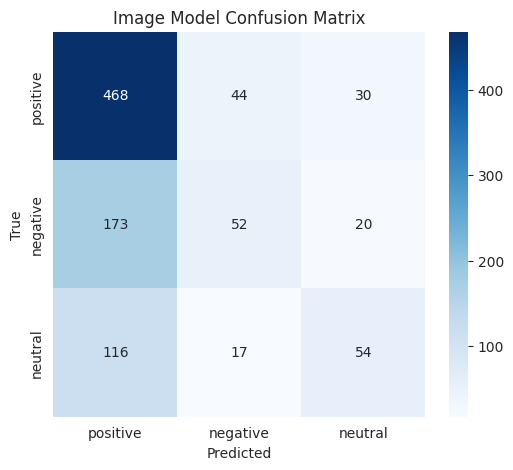

In [11]:
# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(image_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title('Image Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 7️⃣ Part B: Text-Only Model (RNN/LSTM)

Next, we will build a model that uses only the text from the tweets.

### 7.1 Define the RNN/LSTM Architecture
**Task**: Create a text classification model using an Embedding layer and an LSTM/GRU layer.

**Requirements**:
- An `nn.Embedding` layer to convert word indices to dense vectors.
- An `nn.LSTM` or `nn.GRU` layer to process the sequence.
- A final `nn.Linear` layer to produce class scores.

In [12]:
# Define the TextModel class
class TextModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super().__init__()
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2,
                            bidirectional=True, batch_first=True, dropout=0.5)
        # Final fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim) # *2 for bidirectional
        self.dropout = nn.Dropout(0.5)

    def forward(self, text):
        # text = [batch size, seq len]
        embedded = self.dropout(self.embedding(text))
        # embedded = [batch size, seq len, emb dim]

        # pack sequence to handle padding
        # packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), batch_first=True, enforce_sorted=False)

        packed_output, (hidden, cell) = self.lstm(embedded)
        # hidden = [num layers * num directions, batch size, hid dim]

        # Concatenate the final forward and backward hidden states
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        # hidden = [batch size, hid dim * 2]

        return self.fc(hidden)

In [13]:
# Initialize the text model
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
text_model = TextModel(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=3,
    pad_idx=PAD_IDX
).to(device)

# Print the model architecture
# print(text_model)

# Count trainable parameters
trainable_params = sum(p.numel() for p in text_model.parameters() if p.requires_grad)
print(f"Text model has {trainable_params:,} trainable parameters.")

Text model has 3,776,683 trainable parameters.


### 7.2 Train and Evaluate the Text Model
**Task**: Train and evaluate the text-only model using the same process as before.

In [14]:
# Instantiate the loss function and optimizer for the text model
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(text_model.parameters(), lr=LEARNING_RATE)

# --- Training Loop for Text Model ---
print("Training Text-Only Model...")
for epoch in range(NUM_EPOCHS):
    text_model.train()
    running_loss = 0.0
    for _, texts, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        texts, labels = texts.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = text_model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

Training Text-Only Model...


Epoch 1/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 1, Loss: 1.0195


Epoch 2/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 2, Loss: 0.9914


Epoch 3/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 3, Loss: 0.9873


Epoch 4/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 4, Loss: 0.9865


Epoch 5/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 5, Loss: 0.9834


Epoch 6/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 6, Loss: 0.9821


Epoch 7/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 7, Loss: 0.9757


Epoch 8/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 8, Loss: 0.9725


Epoch 9/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 9, Loss: 0.9658


Epoch 10/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 10, Loss: 0.9659


In [15]:
# --- Evaluation ---
text_acc, text_cm = evaluate_model(text_model, val_loader, model_type="text")
print(f"\nText Model Validation Accuracy: {text_acc:.4f}")


Text Model Validation Accuracy: 0.5462


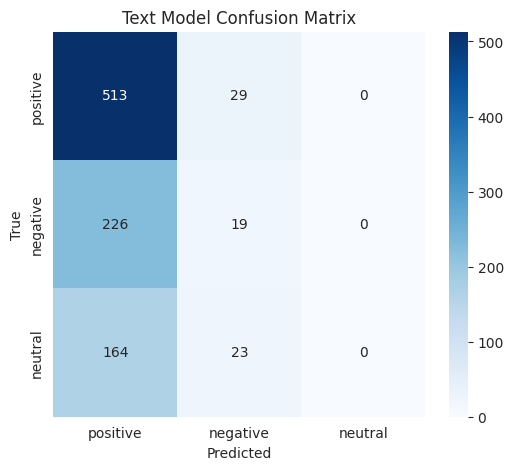

In [16]:
# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(text_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title('Text Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 8️⃣ Part C: Combined Multimodal Model

Finally, we'll combine the two feature extractors into a single, powerful model.

### 8.1 Define the Multimodal Architecture
**Task**: Create a model that takes both an image and text as input.

**Requirements**:
- Use the pre-trained image CNN (without its final classifier layer) as an image feature extractor.
- Use the trained text model (without its final classifier layer) as a text feature extractor.
- Concatenate the features from both branches.
- Add one or more `nn.Linear` layers to classify the combined feature vector.

In [19]:
# Define the MultiModalModel class
class MultiModalModel(nn.Module):
    def __init__(self, text_model, image_model):
        super().__init__()
        # Image feature extractor (ResNet without final FC layer)
        self.image_features = nn.Sequential(*list(image_model.children())[:-1])
        # Text feature extractor (TextModel without final FC layer)
        self.text_features = text_model
        # Freeze image model parameters
        for param in self.image_features.parameters():
            param.requires_grad = False

        # Get feature dimensions
        image_feature_dim = 512 # ResNet18 output
        text_feature_dim = text_model.fc.in_features

        # Classifier for combined features
        self.classifier = nn.Sequential(
            nn.Linear(image_feature_dim + text_feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 3)
        )

    def forward(self, image, text):
        # Get image features
        img_feats = self.image_features(image)
        img_feats = img_feats.view(img_feats.size(0), -1) # Flatten

        # Get text features (from the hidden state of the text model)
        # We need to call the text model parts manually
        embedded = self.text_features.dropout(self.text_features.embedding(text))
        packed_output, (hidden, cell) = self.text_features.lstm(embedded)
        txt_feats = self.text_features.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))

        # Concatenate features
        combined_feats = torch.cat((img_feats, txt_feats), dim=1)

        # Classify
        output = self.classifier(combined_feats)
        return output



In [20]:
# Initialize the multimodal model
# Note: We pass instances of the previously defined models
multimodal_model = MultiModalModel(text_model, image_model).to(device)

# Count trainable parameters (should be text model + new classifier)
trainable_params = sum(p.numel() for p in multimodal_model.parameters() if p.requires_grad)
print(f"Multimodal model has {trainable_params:,} trainable parameters.")

Multimodal model has 4,039,854 trainable parameters.


### 8.2 Train and Evaluate the Multimodal Model
**Task**: Train and evaluate the final combined model.

In [21]:
# Instantiate the loss function and optimizer for the multimodal model
criterion = nn.CrossEntropyLoss()
# We only train the text part and the new classifier
optimizer = optim.AdamW(
    [p for p in multimodal_model.parameters() if p.requires_grad],
    lr=LEARNING_RATE
)

# --- Training Loop for Multimodal Model ---
print("Training Multimodal Model...")
for epoch in range(NUM_EPOCHS):
    multimodal_model.train()
    running_loss = 0.0
    for images, texts, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        images, texts, labels = images.to(device), texts.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = multimodal_model(images, texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

Training Multimodal Model...


Epoch 1/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 1, Loss: 0.9801


Epoch 2/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 2, Loss: 0.9044


Epoch 3/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 3, Loss: 0.8604


Epoch 4/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 4, Loss: 0.8415


Epoch 5/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 5, Loss: 0.8199


Epoch 6/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 6, Loss: 0.8019


Epoch 7/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 7, Loss: 0.7949


Epoch 8/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 8, Loss: 0.7775


Epoch 9/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 9, Loss: 0.7650


Epoch 10/10:   0%|          | 0/61 [00:00<?, ?it/s]

Epoch 10, Loss: 0.7478


In [22]:
# --- Evaluation ---
multimodal_acc, multimodal_cm = evaluate_model(multimodal_model, val_loader, model_type="multimodal")
print(f"\nMultimodal Model Validation Accuracy: {multimodal_acc:.4f}")


Multimodal Model Validation Accuracy: 0.6150


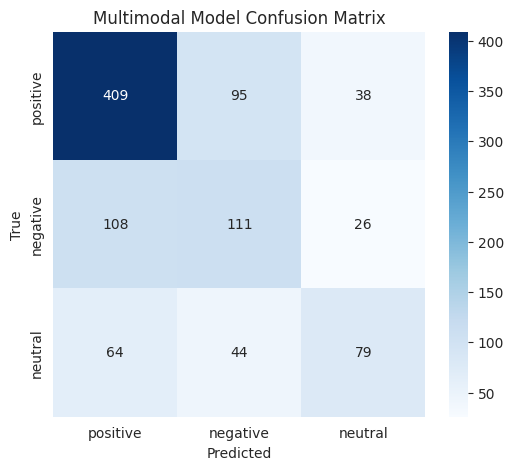

In [23]:
# Plotting the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(multimodal_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title('Multimodal Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## 9️⃣ Performance Comparison

**Task**: Present the results of all three models side-by-side.

**Requirements**:
- Display the final validation accuracies for the Image-Only, Text-Only, and Multimodal models.
- Plot the confusion matrices for all three models in a single figure for easy comparison.

In [24]:
# Print the final validation accuracies in a summary
print("--- Final Model Performance ---")
print(f"Image-Only Model Accuracy:   {image_acc:.4f}")
print(f"Text-Only Model Accuracy:    {text_acc:.4f}")
print(f"Multimodal Model Accuracy:   {multimodal_acc:.4f}")
print("-----------------------------")

--- Final Model Performance ---
Image-Only Model Accuracy:   0.5893
Text-Only Model Accuracy:    0.5462
Multimodal Model Accuracy:   0.6150
-----------------------------


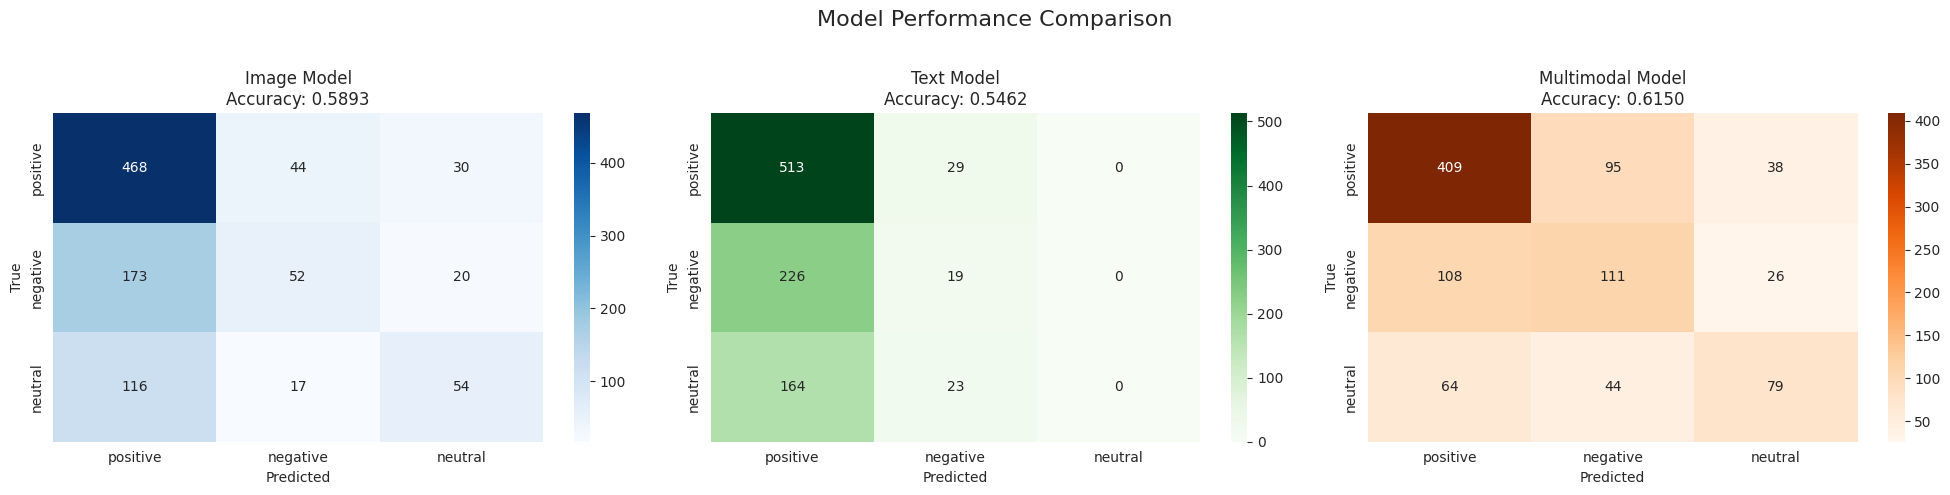

In [25]:
# Create a 1x3 subplot to display all confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Model Performance Comparison', fontsize=16)

# Plot for Image Model
sns.heatmap(image_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=label_map.keys(), yticklabels=label_map.keys())
axes[0].set_title(f'Image Model\nAccuracy: {image_acc:.4f}')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Plot for Text Model
sns.heatmap(text_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=label_map.keys(), yticklabels=label_map.keys())
axes[1].set_title(f'Text Model\nAccuracy: {text_acc:.4f}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

# Plot for Multimodal Model
sns.heatmap(multimodal_cm, annot=True, fmt='d', cmap='Oranges', ax=axes[2],
            xticklabels=label_map.keys(), yticklabels=label_map.keys())
axes[2].set_title(f'Multimodal Model\nAccuracy: {multimodal_acc:.4f}')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')

# Display the final plot
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
plt.show()

## 📝 Evaluation Criteria

Your homework will be evaluated based on:

1.  **Implementation Correctness (40%)**
    - Correct implementation of all three model architectures (CNN, RNN/LSTM, Combined).
    - Proper data loading, preprocessing, and splitting.
    - Working training and evaluation loops for each model.

2.  **Model Training and Results (30%)**
    - All three models train without errors.
    - Loss decreases over epochs.
    - Final models produce reasonable predictions on the validation set.

3.  **Code Quality (20%)**
    - Clean, readable code with comments explaining key parts.
    - Correct use of PyTorch modules, tensor shapes, and data flow.
    - Efficient implementation.

4.  **Comparison and Visualization (10%)**
    - Clear presentation of final accuracies for all models.
    - Correctly generated and clearly labeled confusion matrices for comparison.

# Written by: Ali Habibullah